<h1> Building the model

<h2> Deep Learning

<h3> Preparing the train and test data

In [5]:
train_df = pd.read_csv("preprocessed_train.csv", index_col = "Id")
test_df = pd.read_csv("preprocessed_test.csv", index_col = "Id")

In [6]:
# Let's get our final train data and test data

feature_target = "change_type"

train_df[feature_target] = train_df[feature_target].map({'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5})

In [7]:
train_df = train_df.drop(columns = ["index"])
test_df = test_df.drop(columns = ["index"])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns = [feature_target]), train_df[feature_target], test_size = 0.2)

In [9]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm_train, y_sm_train = sm.fit_resample(X_train, y_train)

<h3> Creating the model

In [10]:
from keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout
import keras

n_outputs = 6

input_ = Input(shape = X_train.shape[1])
input_ = Dropout(0.2)(input_)
hidden1 = Dense(64, activation="elu")(input_)
hidden1 = BatchNormalization()(hidden1)
hidden1 = Dropout(0.2)(hidden1)
hidden2 = Dense(32, activation="elu")(hidden1)
hidden2 = BatchNormalization()(hidden2)
hidden2 = Dropout(0.2)(hidden2)
concat = Concatenate()([hidden2, input_])
concat = BatchNormalization()(concat)
output = Dense(n_outputs, activation= "softmax")(concat)
model = keras.Model(inputs = [input_], outputs = [output])

model.compile(optimizer = "rmsprop", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

2022-01-13 22:07:11.917016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-13 22:07:11.917036: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-13 22:07:13.712391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-13 22:07:13.712419: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-13 22:07:13.712437: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (epideixx-G3-3500): /proc/driver/nvidia/version does not exist
2022-01-13 22:07:13.712584: I tensorflow/core/platform/cpu_f

In [11]:
X_train

,date2,date3,date4,date5,geometry,Dense Urban,Industrial,None,Rural,Sparse Urban,...,change_status_date5_Construction Done,change_status_date5_Construction Midway,change_status_date5_Construction Started,change_status_date5_Excavation,change_status_date5_Greenland,change_status_date5_Land Cleared,change_status_date5_Materials Dumped,change_status_date5_NA,change_status_date5_Operational,change_status_date5_Prior Construction
Id,,,,,,,,,,,,,,,,,,,,,
289425,151,903,1471,1866,4.751322e-09,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
143552,363,602,1097,1403,8.000758e-08,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
18924,294,918,1320,2057,2.443948e-09,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
193593,565,860,1684,2156,2.642707e-07,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
194670,332,1137,1406,1983,3.230128e-08,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160838,898,1105,1534,2110,2.450035e-07,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
281255,573,980,993,1731,2.641659e-09,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
111518,213,592,934,1425,1.263812e-07,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


In [11]:
# The main issue is that it's going to affect the future validation data too ...

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer

dates = ["date2", "date3", "date4", "date5"]

ct = ColumnTransformer([
        ('date_scaler', StandardScaler(), dates),
        ('geometry_scaler', RobustScaler(), ["geometry"])
    ], remainder='passthrough')

X_train = ct.fit_transform(X_train)
X_sm_train = ct.fit_transform(X_sm_train)
X_test = ct.transform(X_test)


In [12]:
X_final = test_df
X_final = ct.transform(X_final)

In [9]:
np.shape(X_train)

(248004, 73)

In [14]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)

class_weights = {i : e for i, e in enumerate(class_weights)}

In [15]:
from keras.callbacks import EarlyStopping

cb_EarlyStopping = EarlyStopping(patience=10)

history = model.fit(X_sm_train, y_sm_train, batch_size = 128, epochs = 30, validation_split = 0.2, callbacks = [cb_EarlyStopping], class_weight= None)

Epoch 1/30
4915/4915 [==============================] - 11s 2ms/step - loss: 0.6388 - accuracy: 0.7413 - val_loss: 18.7396 - val_accuracy: 0.1533
Epoch 2/30
4915/4915 [==============================] - 10s 2ms/step - loss: 0.6295 - accuracy: 0.7450 - val_loss: 17.4516 - val_accuracy: 0.1564
Epoch 3/30
4915/4915 [==============================] - 10s 2ms/step - loss: 0.6245 - accuracy: 0.7474 - val_loss: 17.1807 - val_accuracy: 0.1521
Epoch 4/30
4915/4915 [==============================] - 10s 2ms/step - loss: 0.6213 - accuracy: 0.7488 - val_loss: 16.6044 - val_accuracy: 0.1500
Epoch 5/30
4915/4915 [==============================] - 10s 2ms/step - loss: 0.6181 - accuracy: 0.7499 - val_loss: 17.6821 - val_accuracy: 0.1529
Epoch 6/30
4915/4915 [==============================] - 10s 2ms/step - loss: 0.6163 - accuracy: 0.7506 - val_loss: 17.2543 - val_accuracy: 0.1534
Epoch 7/30
4915/4915 [==============================] - 11s 2ms/step - loss: 0.6143 - accuracy: 0.7513 - val_loss: 18.1501 -

In [16]:
model.evaluate(X_test, y_test)

1938/1938 [==============================] - 1s 723us/step - loss: 0.7590 - accuracy: 0.6813


[0.7590062022209167, 0.681348979473114]

In [19]:
y_test = np.argmax(model.predict(X_final), axis = -1)
print(y_test)
pred_df = pd.DataFrame(y_test, columns=['change_type'])
pred_df.to_csv('nn_sample_submission.csv', index = True, index_label = 'Id')

7


ValueError: DataFrame constructor not properly called!

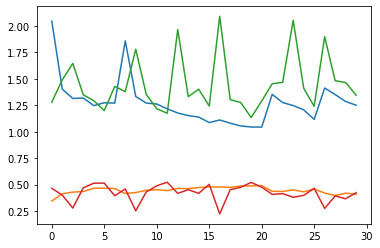

In [141]:
plt.plot(pd.DataFrame(history.history))

<h2> Others models

In [142]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0).fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.6551885423050869

In [36]:
from sklearn.ensemble import RandomForestClassifier

clf_rndForest = RandomForestClassifier().fit(X_train, y_train)

clf_rndForest.score(X_test, y_test)

0.7304925647559756

In [37]:
clf_rndForest.score(X_test, y_test)

0.7304925647559756

In [38]:
y_test = clf_rndForest.predict(X_final)

In [39]:
pred_df = pd.DataFrame(y_test, columns=['change_type'])
pred_df.to_csv('lgb_sample_submission.csv', index = True, index_label = 'Id')

In [17]:
from sklearn.svm import SVC

clf = SVC().fit(X_train, y_train)

clf.score(X_test, y_test)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=8).fit(X_train, y_train)

clf.score(X_test, y_test)

0.7098803264410826